# Scale-Dependent Modification of Power Spectrum Multipoles

Initiate notebook.

In [1]:
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import Planck15

import conf
from horizonground.lumfunc_modeller import (
    LumFuncModeller,
    alpha_emitter_schechter_model,
    quasar_PLE_model,
    quasar_hybrid_model,
)
from horizonground.clustering_modification import (
    non_gaussianity_factor,
    relativistic_correction_func,
    relativistic_factor,
    standard_kaiser_factor,
)

%matplotlib notebook

LEGEND_SETTINGS = dict(
    handlelength=1.2, 
    handletextpad=0.5,
    fontsize=16,
)

Define fiducial parameters and parameter ranges.

In [2]:
FIDUCIAL_REDSHIFT = 2.
FIDUCIAL_LINEAR_BIAS = 2.
FIDUCIAL_NON_GAUSSNIANTY = 1.

In [3]:
wavenumbers = np.logspace(-3.5, -1.5, num=200+1)
redshifts = np.linspace(0.5, 2., num=150+1)
orders = [0, 2]

Define tracer sample.

In [4]:
TRACER_SAMPLE = 'QSO'  # 'H-alpha', 'QSO'
if TRACER_SAMPLE.upper().startswith('Q'):
    p = 1.6
elif TRACER_SAMPLE.upper().startswith('H'):
    p = 1

## Evolution and magnification biases

Specify luminosity function model.

In [5]:
if TRACER_SAMPLE.upper().startswith('Q'):
    modeller = LumFuncModeller.from_parameters_file(
        parameter_file="../data/external/PLE_model_fits.txt",
        lumfunc_model=quasar_PLE_model,
        brightness_variable='magnitude',
        threshold_value=-21.80,
        threshold_variable='magnitude',
        cosmology=Planck15,
        base10_log=False
    )
elif TRACER_SAMPLE.upper().startswith('H'):
    modeller = LumFuncModeller.from_parameters_file(
        parameter_file="../data/external/Schechter_model_fits.txt",
        lumfunc_model=alpha_emitter_schechter_model,
        brightness_variable='luminosity',
        threshold_value=3.e-16,
        threshold_variable='flux',
        cosmology=Planck15,
        base10_log=False
    )

evolution_bias = modeller.evolution_bias
magnification_bias = modeller.magnification_bias

Text(0.5, 1.0, 'QSO')

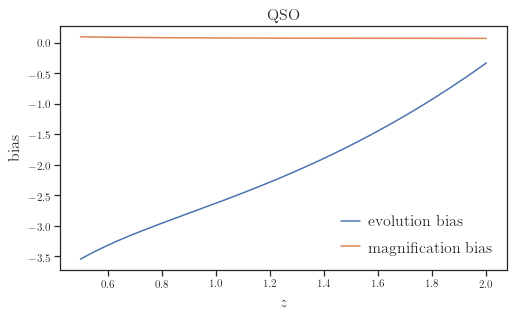

In [6]:
z = redshifts

plt.figure("Relativistic bias", figsize=(8, 4.5))

plt.plot(z, list(map(evolution_bias, z)), label="evolution bias")
plt.plot(z, list(map(magnification_bias, z)), label="magnification bias")

plt.legend(**LEGEND_SETTINGS)
plt.xlabel(r"$z$", fontsize=16)
plt.ylabel(r"bias", fontsize=16)
plt.title(TRACER_SAMPLE, fontsize=16)

## Relavitstic correction terms

Text(0.5, 1.0, 'QSO')

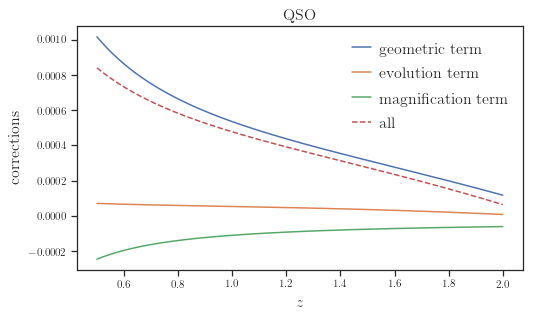

In [7]:
corrections_geom = relativistic_correction_func()
corrections_evol = relativistic_correction_func(
    geometric=False, evolution_bias=evolution_bias
)
corrections_magn = relativistic_correction_func(
    geometric=False, magnification_bias=magnification_bias
)
corrections_all = relativistic_correction_func(
    evolution_bias=evolution_bias, magnification_bias=magnification_bias
)

plt.figure("Relativistic corrections", figsize=(8, 4.5))

plt.plot(redshifts, corrections_geom(redshifts), label="geometric term")
plt.plot(redshifts, corrections_evol(redshifts), label="evolution term")
plt.plot(redshifts, corrections_magn(redshifts), label="magnification term")
plt.plot(redshifts, corrections_all(redshifts), ls='--', label="all")

plt.legend(**LEGEND_SETTINGS)
plt.xlabel(r"$z$", fontsize=16)
plt.ylabel(r"corrections", fontsize=16)
plt.title(TRACER_SAMPLE, fontsize=16)

## Modification results

In [8]:
kaiser_result = {
    ell: standard_kaiser_factor(ell, FIDUCIAL_LINEAR_BIAS, FIDUCIAL_REDSHIFT)
        * np.ones_like(wavenumbers)
    for ell in orders
}

In [9]:
relativistic_result = {
    ell: relativistic_factor(
        wavenumbers, ell, FIDUCIAL_REDSHIFT,
        evolution_bias=evolution_bias, magnification_bias=magnification_bias
    )
    for ell in orders
}

In [10]:
non_gaussianity_result = {
    ell: non_gaussianity_factor(
        wavenumbers, ell,
        FIDUCIAL_NON_GAUSSNIANTY, FIDUCIAL_LINEAR_BIAS, FIDUCIAL_REDSHIFT,
        tracer_param=p
    )
    for ell in orders   
}

We now show the amount of modification relative to the standard Kaiser power spectrum multipoles.

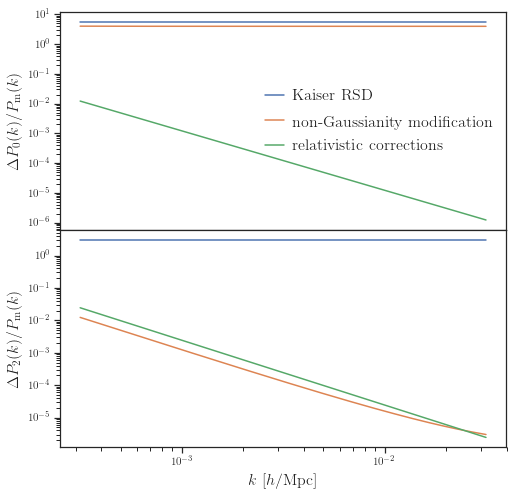

In [11]:
plt.figure("Power multipole factors", figsize=(8, 8))

monopole = plt.subplot2grid((2, 1), (0, 0))

monopole.loglog(
    wavenumbers, kaiser_result[0] * np.ones_like(wavenumbers), 
    label="Kaiser RSD"
)
monopole.loglog(
    wavenumbers, non_gaussianity_result[0],
    label="non-Gaussianity modification"
)
monopole.loglog(
    wavenumbers, relativistic_result[0], 
    label="relativistic corrections"
)

monopole.legend(**LEGEND_SETTINGS)
monopole.get_xaxis().set_visible(False)
monopole.set_ylabel(r"$\Delta P_0(k) / P_\mathrm{m}(k)$", fontsize=16)

quadrupole = plt.subplot2grid((2, 1), (1, 0), sharex=monopole)

quadrupole.loglog(wavenumbers, kaiser_result[2] * np.ones_like(wavenumbers))
quadrupole.loglog(wavenumbers, non_gaussianity_result[2])
quadrupole.loglog(wavenumbers, relativistic_result[2])

quadrupole.set_xlabel(r"$k$ [$h$/Mpc]", fontsize=16)
quadrupole.set_ylabel(r"$\Delta P_2(k) / P_\mathrm{m}(k)$", fontsize=16)

plt.subplots_adjust(wspace=0, hspace=0)